# Create Land Surface Temparature (LST) map from Landsat 8 data

To make this Notebook work, download the Landsat 8 files from the [**USGS Earth Explorer**](https://earthexplorer.usgs.gov/) and place it in the directory defined below as `dir_source`. The directory name should be the original Landsat ID, which has to be provided below as `landsat_id`.

To **download the satellite imagery**, you need an account for the USGS Earth Explorer (free of charge). Then you can open https://earthexplorer.usgs.gov/ and

1. **Define a bounding box:** Find a place on earth you want to use. A simple way is to use the map currently displayed as bounding box. Once you have moved and zoomed in to your likings, click ***Use Map*** under ***Polygon*** in the left hand column.

2. **Define date range and cloud cover:** To search for available satellite images, define a date range and acceptable cloud cover under ***Date Range*** and ***Cloud Cover*** in the left column.

3. **Select data set:** Click on ***Data Sets*** and navigate to and select ***Landsat*** &rarr; ***Landsat Collection 2 Level 1*** &rarr; ***Landsat 8-9 OLI/TIRS C2 L1*** (find more information on [Level 1](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-landsat-archives-landsat-8-9-operational-land-imager-and) and [Level 2](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-landsat-archives-landsat-8-9-olitirs-collection-2-level-2) data). Click on ***Results***.

4. **Find an image:** The results show any satellite imagery that overlaps in any part with the defined bounding box. By clicking on the **footprint symbol** you can see the area covered by the image. Go through the images to find one that suits your needs and overlaps enough.

5. **Download the files:** Click on the ***download symbol*** (*Download Options*), click ***Product Options***, click to download next to ***Landsat Collection 2 Level-1 Product Bundle***.

6. **Extract the files:** Extract the files and move the folder to the directory defined under `dir_source`. Define the `landsat_id` below.



In [105]:
import os
import sys
from pathlib import Path

import folium
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.mask

In [106]:
# Add the parent directory to the path to make imports work
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import utils

### Paths

In [149]:
# ID of the Landsat 8 files (example is Berlin)
landsat_id = "LC09_L1TP_193023_20220624_20230409_02_T1"

# GeoJSON file with the bounding box of the area we are interested in
# Needs to exist in the directory defined below ("geojson_path")
# Needs to overlap with the Landsat 8 image downloaded above
# You can use https://geojson.io/ to create the file
geojson_file = "berlin.geojson"

In [154]:
# Base directory for all files
dir_data = Path("../data")

# Base directory for Landsat files
dir_data_landsat = Path(dir_data, "landsat")

# The source directory contains the original Landsat files
# Its name is the original Landsat ID (set above)
dir_source = Path(dir_data_landsat, "source", landsat_id)

# The output directory will contain the preprocessed files
dir_output = Path(dir_data_landsat, "output", landsat_id)

# Create the directories if they do not exist
for directory in [dir_data_landsat, dir_output]:
    Path(directory).mkdir(parents=True, exist_ok=True)

# File paths
geojson_path = Path(dir_data, "geojson", geojson_file)
mtl_path = Path(dir_source, landsat_id + "_MTL.txt")

# Bands
band_4_path = Path(dir_source, landsat_id + "_B4.TIF")  # Red 
band_5_path = Path(dir_source, landsat_id + "_B5.TIF")  # Near Infrared
band_10_path = Path(dir_source, landsat_id + "_B10.TIF") # Thermal Infrared

for band_path in [band_4_path, band_5_path, band_10_path]:
    if not band_path.exists():
        raise FileNotFoundError(f"File not found: {band_path}")

# Paths clipped to GeoJson
band_4_clipped_path = utils.clip_to_geojson(band_4_path, geojson_path, dir_output)
band_5_clipped_path = utils.clip_to_geojson(band_5_path, geojson_path, dir_output)
band_10_clipped_path = utils.clip_to_geojson(band_10_path, geojson_path, dir_output)

# Output file paths
file_lst = Path(dir_output, "temperature_lst.tif")
file_lst_repr = Path(dir_output, "temperature_lst_reprojected.tif")
file_lst_repr_colored = Path(dir_output, "temperature_lst_reprojected_colored.tif")

file_ndvi = Path(dir_output, "ndvi.tif")
file_ndvi_repr = Path(dir_output, "ndvi_reprojected.tif")
file_ndvi_repr_colored = Path(dir_output, "ndvi_reprojected_colored.tif")

file_emissivity = Path(dir_output, "emissivity.tif")
file_emissivity_repr = Path(dir_output, "emissivity_reprojected.tif")
file_emissivity_repr_colored = Path(dir_output, "emissivity_reprojected_colored.tif")

FileNotFoundError: File not found: ../data/landsat/source/LC09_L1TP_193023_20220624_20230409_02_T1/LC09_L1TP_193023_20220624_20230409_02_T1_B4.TIF

### Calculate metrics

In [151]:
ndvi = utils.calc_ndvi(band_4_clipped_path, band_5_clipped_path, file_ndvi)

Saved NDVI to ../data/landsat/output/LC09_L1TP_193023_20220624_20230409_02_T1/ndvi.tif


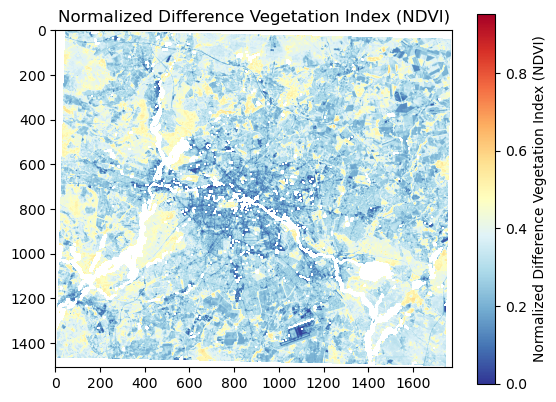

In [136]:
# Show image
plt.imshow(ndvi, cmap="RdYlBu_r")
plt.colorbar(label="Normalized Difference Vegetation Index (NDVI)")
plt.title("Normalized Difference Vegetation Index (NDVI)")
plt.show()

In [137]:
lst = utils.calc_lst(
    band_4_clipped_path, band_5_clipped_path, band_10_clipped_path, file_lst
)

Saved Land Surface Temperature (LST) to ../data/landsat/output/LC09_L1TP_193023_20220624_20230409_02_T1/temperature_lst.tif


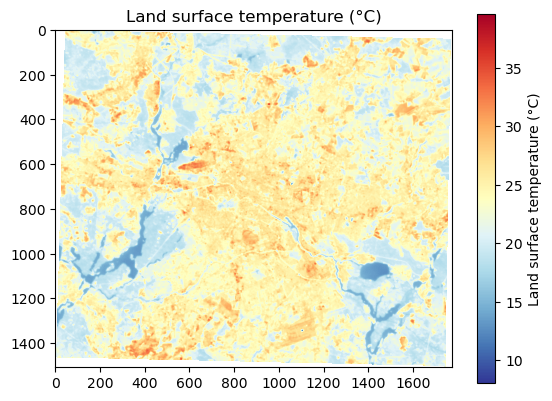

In [138]:
# Show image
plt.imshow(lst, cmap="RdYlBu_r")
plt.colorbar(label="Land surface temperature (°C)")
plt.title("Land surface temperature (°C)")
plt.show()

In [139]:
emissivity = utils.calc_emissivity(
    band_4_clipped_path, band_5_clipped_path, file_emissivity
)

Saved Emissivity to ../data/landsat/output/LC09_L1TP_193023_20220624_20230409_02_T1/emissivity.tif


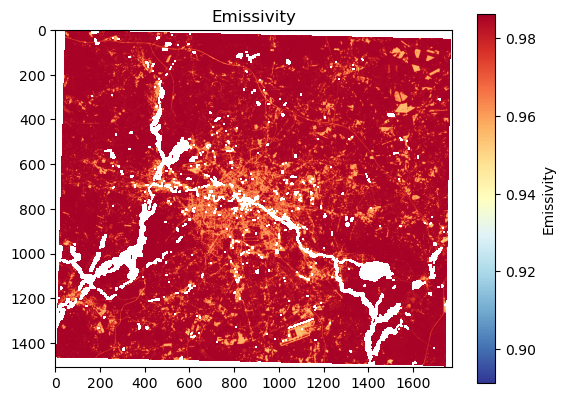

In [140]:
# Show image
plt.imshow(emissivity, cmap="RdYlBu_r")
plt.colorbar(label="Emissivity")
plt.title("Emissivity")
plt.show()

### Change projection

In [141]:
reprojected_ndvi, reprojected_ndvi_array = utils.reproject_geotiff(
    file_ndvi, file_ndvi_repr, 4326
)
reprojected_img, reprojected_img_array = utils.reproject_geotiff(
    file_lst, file_lst_repr, 4326
)
reprojected_emissivity, reprojected_emissivity_array = utils.reproject_geotiff(
    file_emissivity, file_emissivity_repr, 4326
)

Text(0.5, 1.0, 'Land surface temperature (°C)')

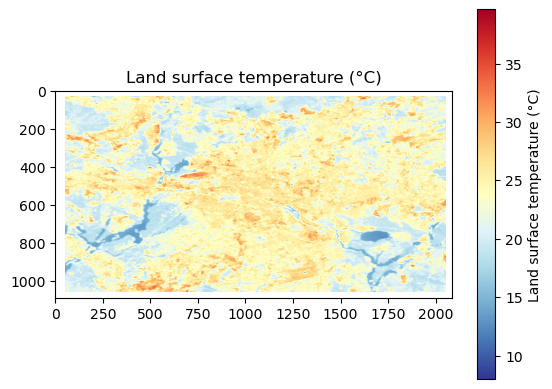

In [142]:
# Show reprojected landsat image for LST
with rasterio.open(file_lst_repr) as src:
    temperature_reprojected = src.read(1)

plt.imshow(temperature_reprojected, cmap="RdYlBu_r")
plt.colorbar(label="Land surface temperature (°C)")
plt.title("Land surface temperature (°C)")

### Change colors

In [143]:
colored_img_ndvi, colored_img_ndvi_array = utils.create_rgba_color_image(
    reprojected_ndvi.name, file_ndvi_repr_colored
)
colored_img, colored_img_array = utils.create_rgba_color_image(
    reprojected_img.name, file_lst_repr_colored
)
colored_img_emissivity, colored_img_emissivity_array = utils.create_rgba_color_image(
    reprojected_emissivity.name, file_emissivity_repr_colored
)

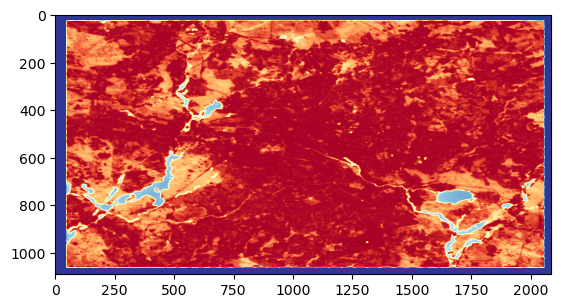

In [144]:
with rasterio.open(file_lst_repr_colored) as src:
    temperature_reprojected_colored = src.read(1)

plt.imshow(temperature_reprojected_colored, cmap="RdYlBu_r");

### Plot Folium temperature map

In [145]:
with rasterio.open(file_ndvi_repr_colored) as colored_ndvi:
    # Load GeoTIFF as ndarray
    colored_ndvi_array = colored_ndvi.read()

    # Move channel axis to third position
    colored_ndvi_array = np.moveaxis(colored_ndvi_array, source=0, destination=2)

In [146]:
with rasterio.open(file_lst_repr_colored) as colored_img:
    # Load GeoTIFF as ndarray
    colored_img_array = colored_img.read()

    # Move channel axis to third position
    colored_img_array = np.moveaxis(colored_img_array, source=0, destination=2)

In [147]:
with rasterio.open(file_emissivity_repr_colored) as colored_emissivity:
    # Load GeoTIFF as ndarray
    colored_emissivity_array = colored_emissivity.read()

    # Move channel axis to third position
    colored_emissivity_array = np.moveaxis(colored_emissivity_array, source=0, destination=2)


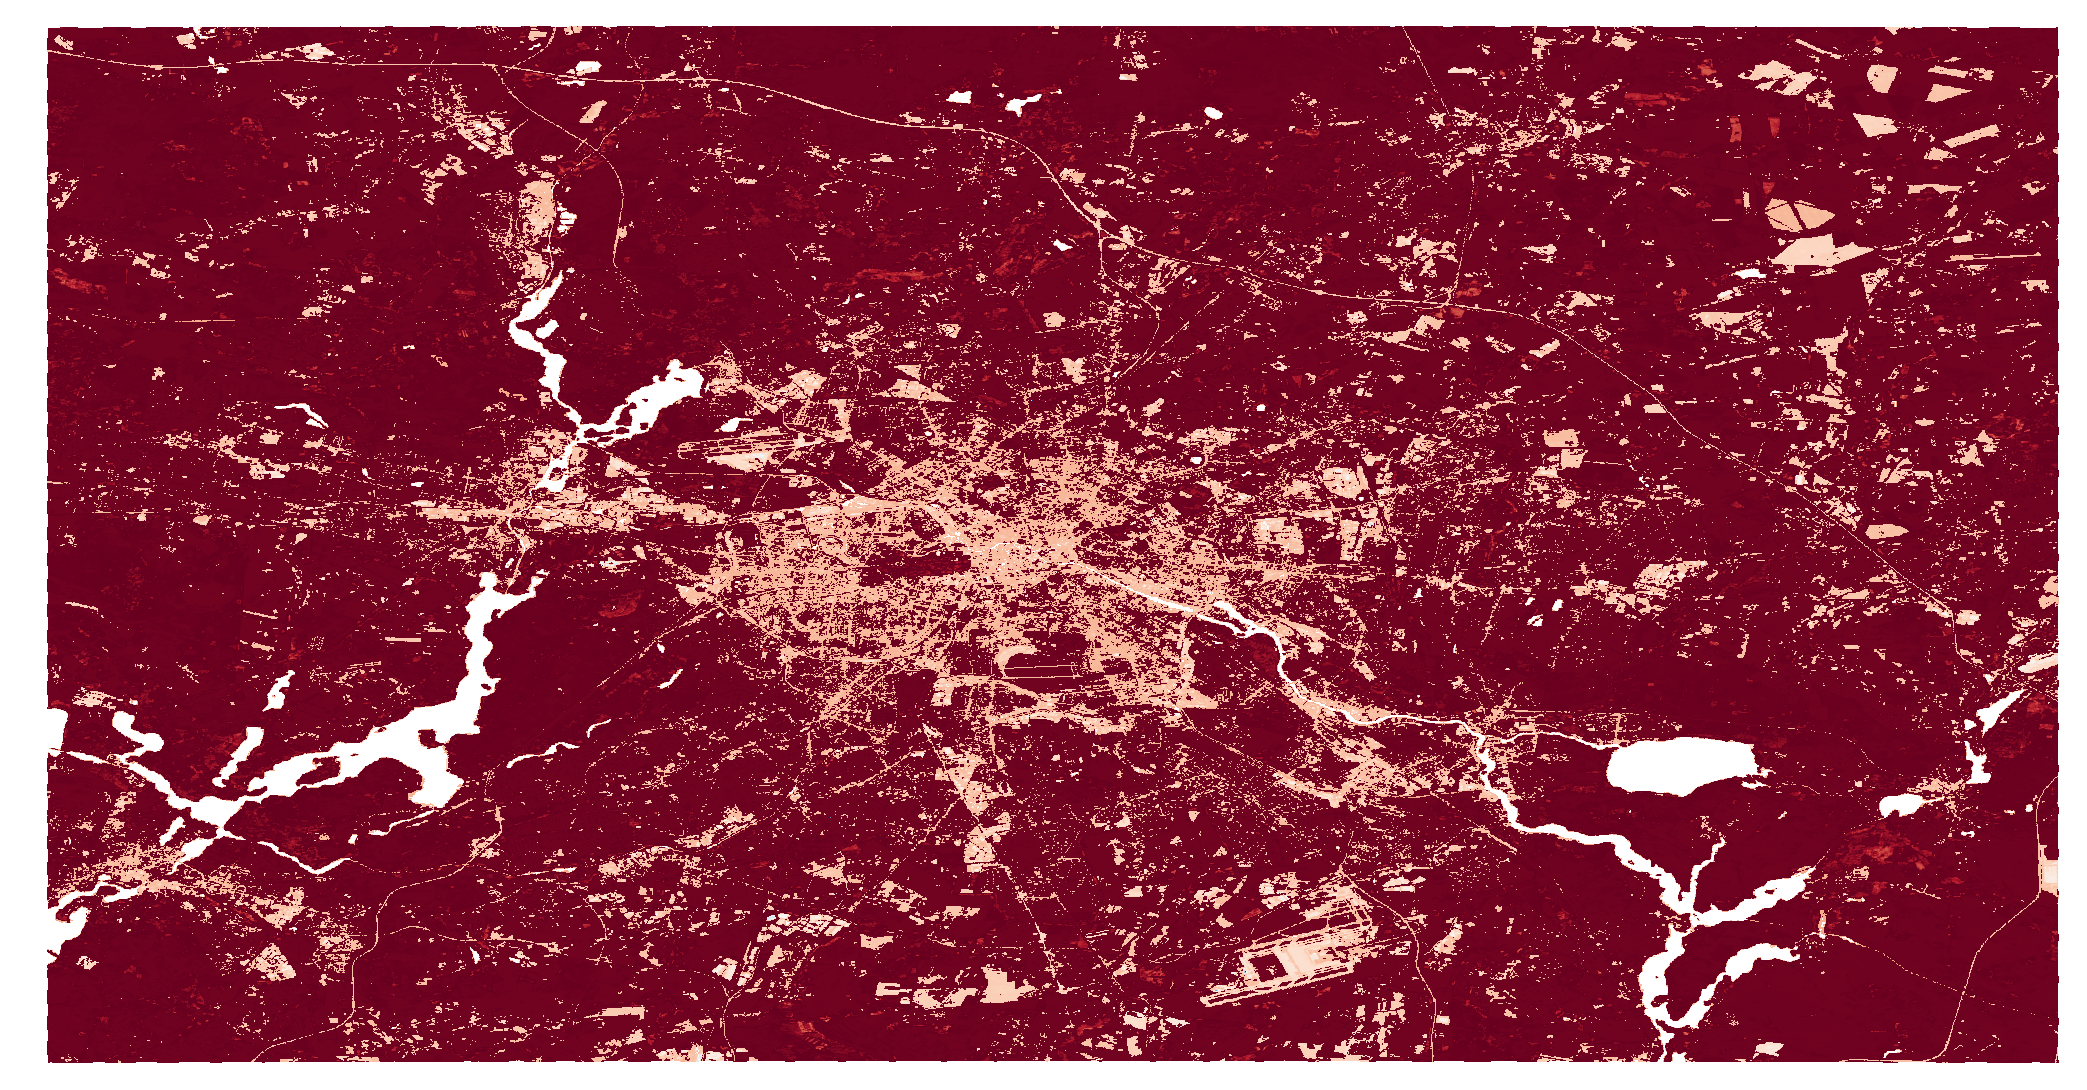
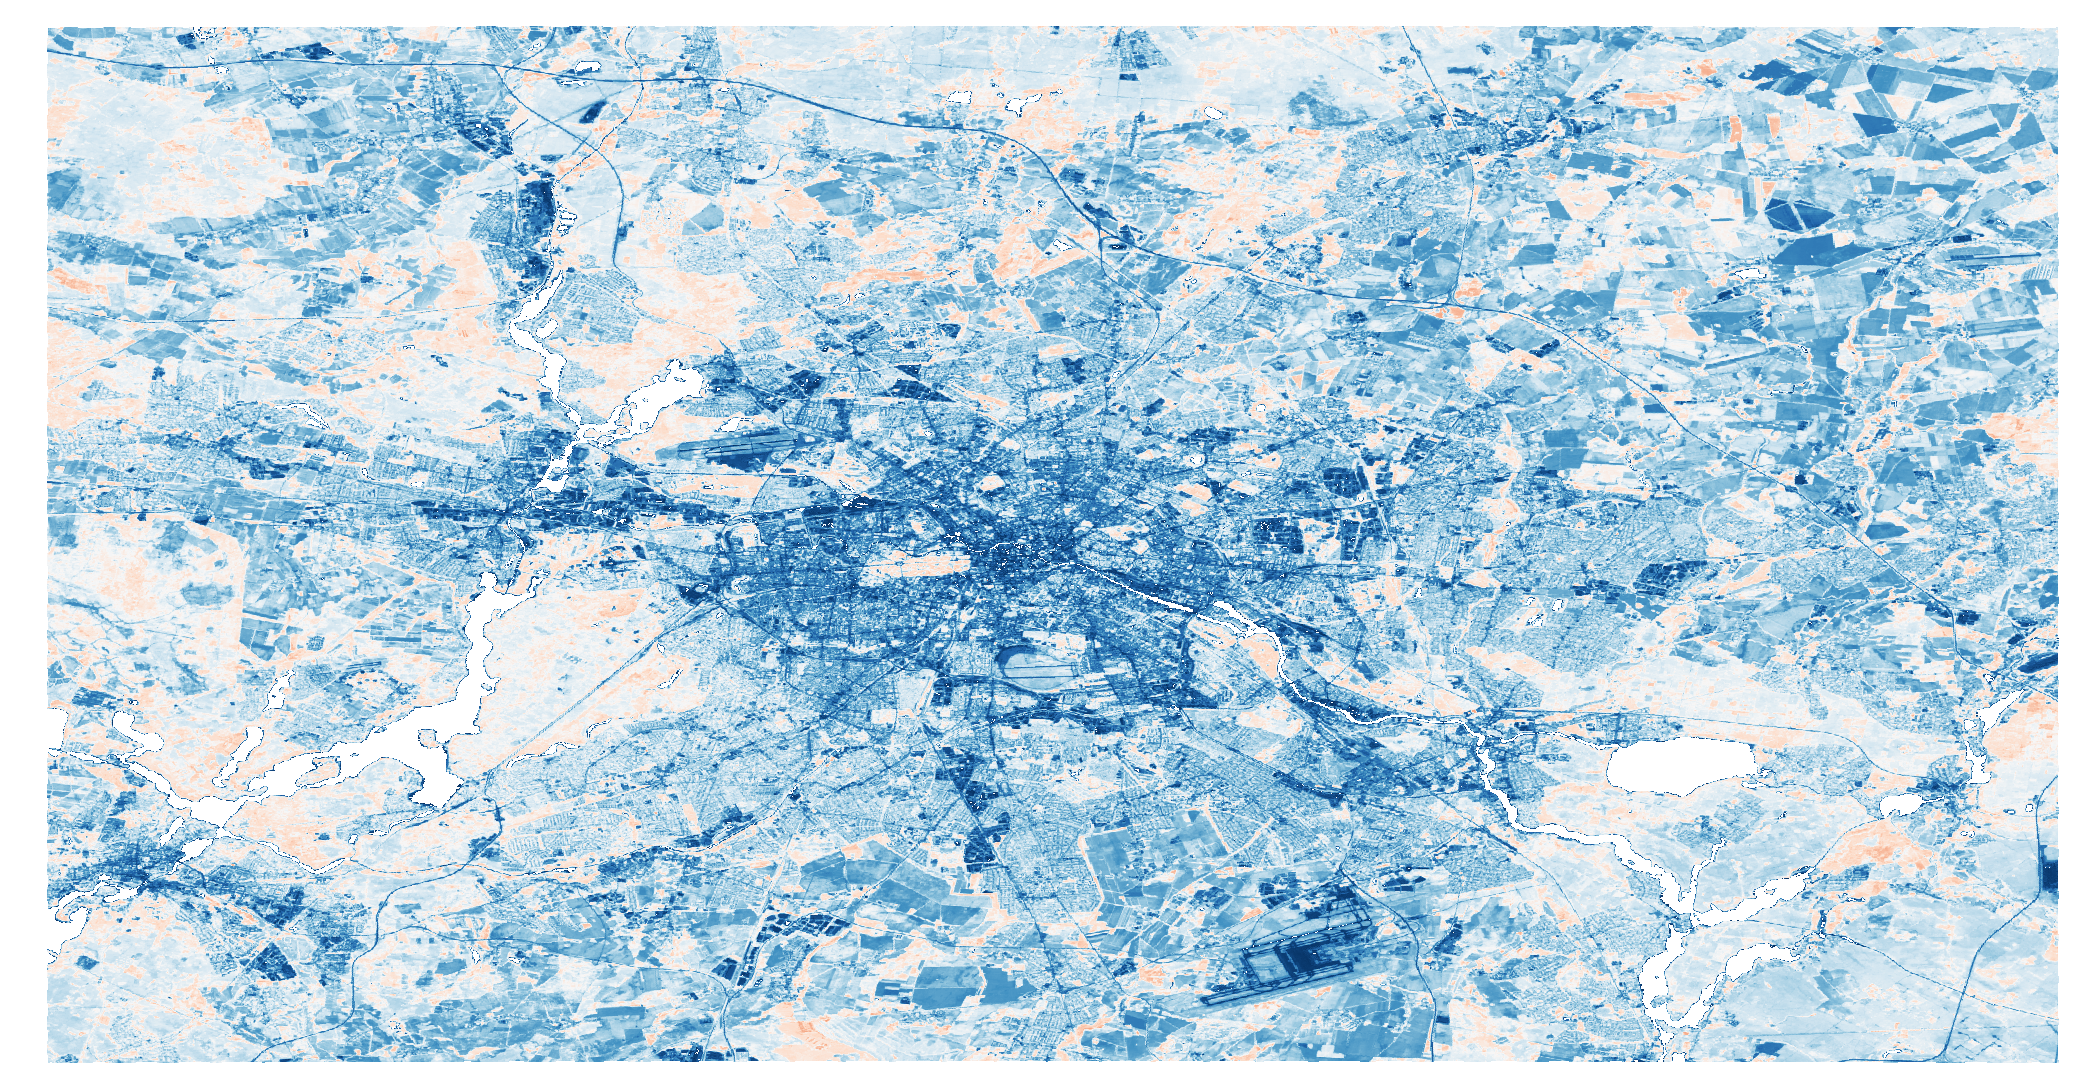
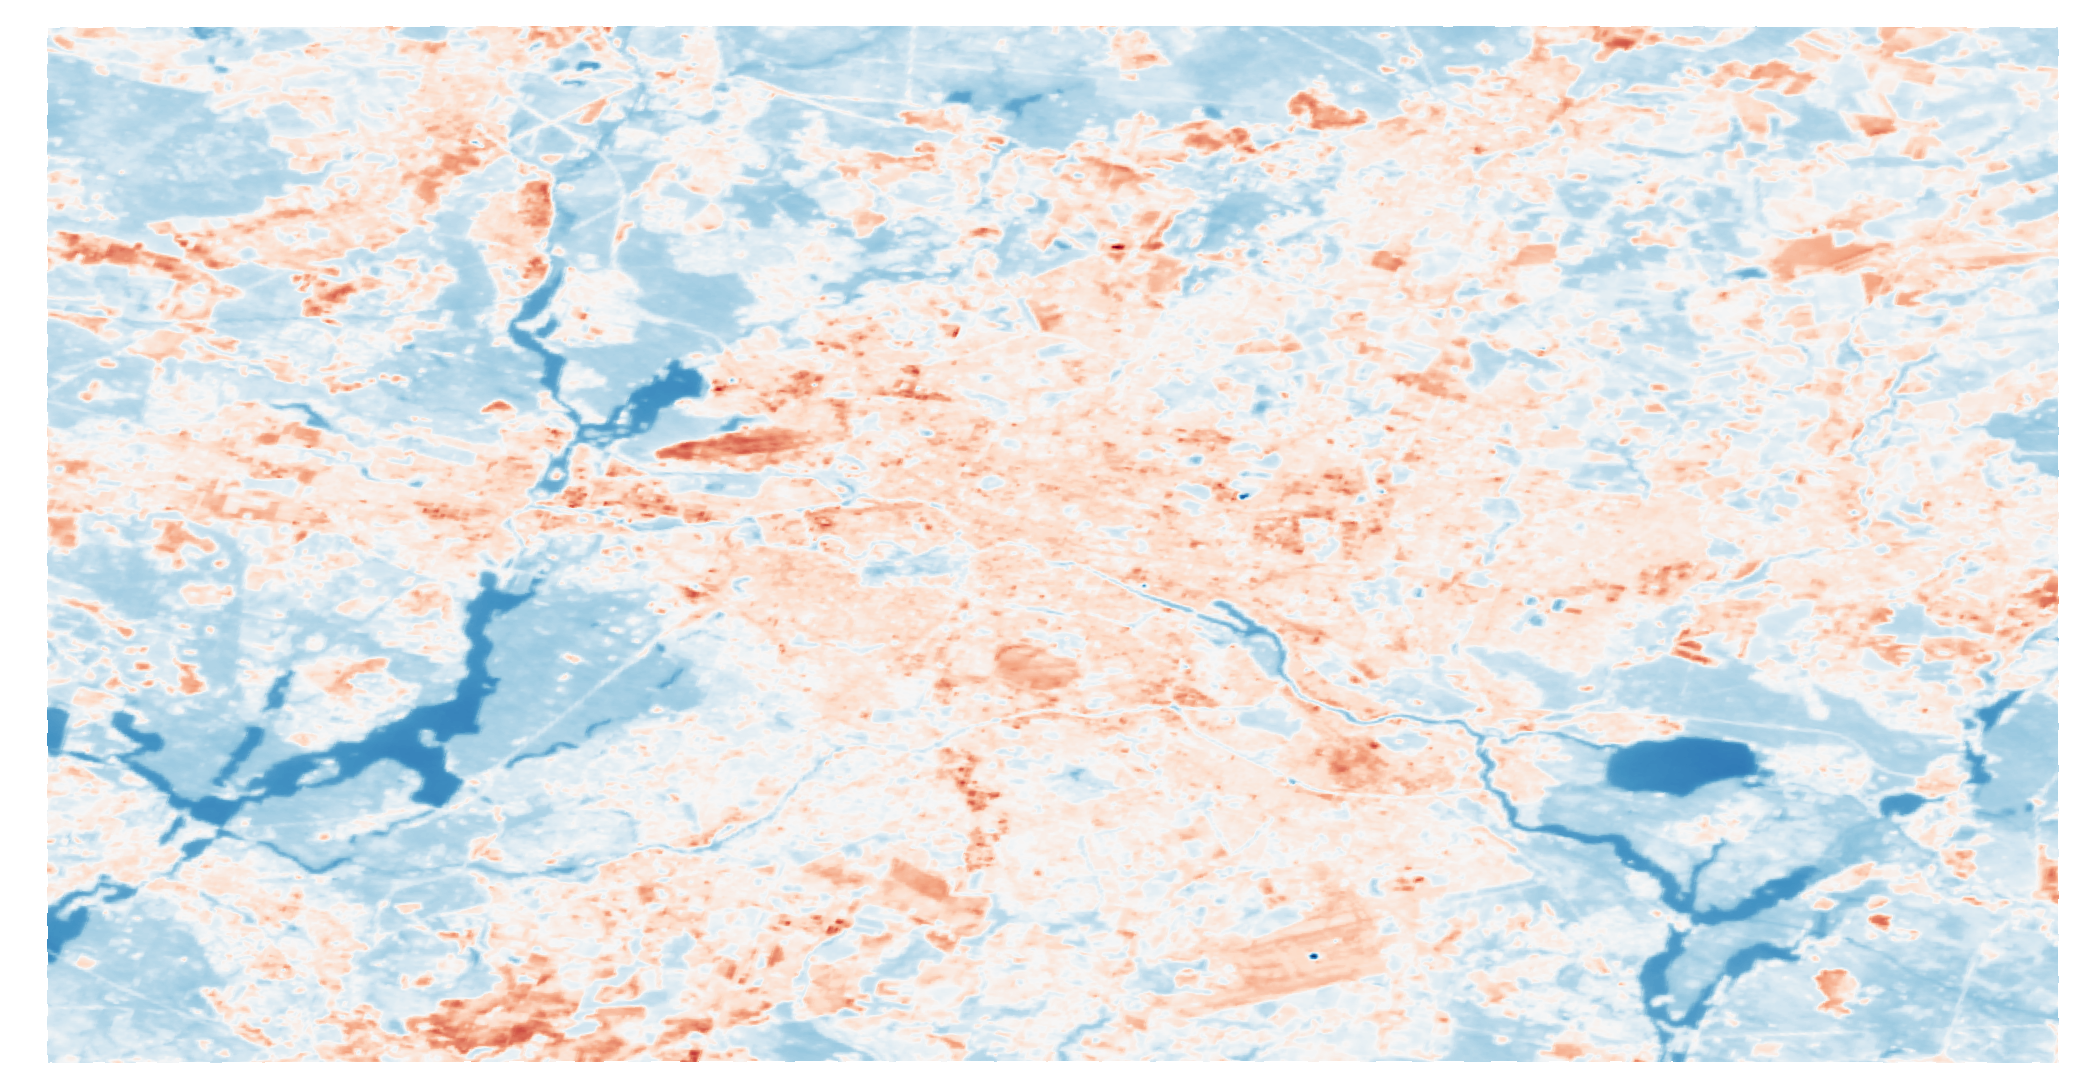

In [148]:
folium_map = folium.Map(
    location=[
        (colored_img.bounds.bottom + colored_img.bounds.top) / 2,
        (colored_img.bounds.left + colored_img.bounds.right) / 2,
    ],
    tiles="Stamen Terrain",
    zoom_start=11,
)

# Add Emissivity layer
folium.raster_layers.ImageOverlay(
    image=colored_emissivity_array,
    name="Emissivity",
    opacity=0.75,
    bounds=[
        [colored_emissivity.bounds.bottom, colored_emissivity.bounds.left],
        [colored_emissivity.bounds.top, colored_emissivity.bounds.right],
    ],
).add_to(folium_map)

# Add NDVI layer
folium.raster_layers.ImageOverlay(
    image=colored_ndvi_array,
    name="Normalized Difference Vegetation Index (NDVI)",
    opacity=0.75,
    bounds=[
        [colored_ndvi.bounds.bottom, colored_ndvi.bounds.left],
        [colored_ndvi.bounds.top, colored_ndvi.bounds.right],
    ],
).add_to(folium_map)

# Add Land Surface Temperature layer
folium.raster_layers.ImageOverlay(
    image=colored_img_array,
    name="Land Surface Temperature",
    opacity=0.75,
    bounds=[
        [colored_img.bounds.bottom, colored_img.bounds.left],
        [colored_img.bounds.top, colored_img.bounds.right],
    ],
).add_to(folium_map)

folium.LayerControl().add_to(folium_map)

folium_map